# Suite2p Headless Demo (No GUI)

This notebook runs a full Suite2p demo on a headless server using demo data. It covers data download, preprocessing, a full pipeline run, and non-GUI review artifacts.

## 1. Configure Headless Environment and Paths

Set headless-friendly environment variables, import dependencies, and define working directories.

In [15]:
%matplotlib inline
import os
import sys
from pathlib import Path
import json
import numpy as np

os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")

import matplotlib
try:
    in_ipython = get_ipython() is not None
except NameError:
    in_ipython = False
if not in_ipython:
    matplotlib.use("Agg")
import matplotlib.pyplot as plt

repo_root = Path.cwd().resolve()
if repo_root.name == "notebooks":
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

import suite2p
from suite2p.run_s2p import run_s2p
from suite2p.parameters import default_db, default_settings

base_dir = Path("/mnt/nas02/Dataset/suite2p")
data_dir = base_dir / "demo"
output_dir = base_dir / "output"

base_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

print("base_dir:", base_dir)
print("data_dir:", data_dir)
print("output_dir:", output_dir)

base_dir: /mnt/nas02/Dataset/suite2p
data_dir: /mnt/nas02/Dataset/suite2p/demo
output_dir: /mnt/nas02/Dataset/suite2p/output


## 2. Load Demo Data

Download (if needed) and verify the demo dataset under the required path.

In [2]:
import subprocess

download_method = "drive-api"  # gdown | drive-api | fallback | skip

tiff_files = list(data_dir.rglob("*.tif")) + list(data_dir.rglob("*.tiff"))
if not tiff_files and download_method != "skip":
    script_path = repo_root / "scripts" / "download_demo_data.py"
    cmd = [sys.executable, str(script_path), "--base-dir", str(base_dir), "--method", download_method]
    print("Running:", " ".join(cmd))
    result = subprocess.run(cmd, check=False)
    if result.returncode != 0:
        raise RuntimeError("Download script failed. Check credentials or network access.")
    tiff_files = list(data_dir.rglob("*.tif")) + list(data_dir.rglob("*.tiff"))

if not tiff_files:
    raise RuntimeError(
        f"No tiff files found in {data_dir}. Please download the demo data and re-run."
    )

print("Using data_dir:", data_dir)
print("Found tiff files:", len(tiff_files))
print("Example file:", tiff_files[0] if tiff_files else "None")

Using data_dir: /mnt/nas02/Dataset/suite2p/demo
Found tiff files: 50
Example file: /mnt/nas02/Dataset/suite2p/demo/file_00002_00001.tif


## 3. Preprocess Demo Data

Run conversion and motion registration only to validate inputs before the full pipeline.

In [3]:
preprocess_dir = output_dir / "preprocess"
preprocess_dir.mkdir(parents=True, exist_ok=True)

pre_db = default_db()
pre_db.update({
    "data_path": [str(data_dir)],
    "save_path0": str(preprocess_dir),
    "fast_disk": str(preprocess_dir),
})

pre_settings = default_settings()
pre_settings["run"]["do_registration"] = 1
pre_settings["run"]["do_detection"] = False
pre_settings["run"]["do_deconvolution"] = False
pre_settings["io"]["save_ops_orig"] = True

pre_ops_path = preprocess_dir / "suite2p" / "plane0" / "ops.npy"
if pre_ops_path.exists():
    print("Preprocess outputs already exist:", pre_ops_path)
else:
    print("Running preprocessing (registration only)...")
    run_s2p(settings=pre_settings, db=pre_db)
    print("Preprocess done.")

Running preprocessing (registration only)...


Preprocess done.


## 4. Set Parameters for Headless Run

Define Suite2p settings and database configuration for the full pipeline run.

In [4]:
run_dir = output_dir / "full_run"
run_dir.mkdir(parents=True, exist_ok=True)

settings = default_settings()
settings["fs"] = 10.0
settings["tau"] = 1.0
settings["diameter"] = [12.0, 12.0]
settings["run"]["do_registration"] = 1
settings["run"]["do_detection"] = True
settings["run"]["do_deconvolution"] = True
settings["io"]["save_ops_orig"] = True

# Optional: speed up quick demos by reducing init frames
# settings["nimg_init"] = 200

db = default_db()
db.update({
    "data_path": [str(data_dir)],
    "save_path0": str(run_dir),
    "fast_disk": str(run_dir),
})

print("Using data_path:", db["data_path"])
print("Saving to:", db["save_path0"])

Using data_path: ['/mnt/nas02/Dataset/suite2p/demo']
Saving to: /mnt/nas02/Dataset/suite2p/output/full_run


## 5. Run Suite2p Pipeline

Execute the full headless pipeline and capture outputs in the run directory.

In [5]:
ops_path = run_dir / "suite2p" / "plane0" / "ops.npy"
if ops_path.exists():
    print("Pipeline outputs already exist:", ops_path)
else:
    print("Running Suite2p pipeline...")
    run_s2p(settings=settings, db=db)
    print("Pipeline done.")

Running Suite2p pipeline...


/home/yz/suite2p/suite2p/extraction/extract.py:68: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  nmasks = nmasks.to_sparse_csc()


Pipeline done.


## 6. Save Outputs and QC Artifacts

Persist summaries and QC artifacts to disk for later inspection.

In [6]:
plane_dir = run_dir / "suite2p" / "plane0"
qc_dir = run_dir / "qc"
qc_dir.mkdir(parents=True, exist_ok=True)

ops = np.load(ops_path, allow_pickle=True).item()
stat = np.load(plane_dir / "stat.npy", allow_pickle=True)
iscell = np.load(plane_dir / "iscell.npy", allow_pickle=True)
F = np.load(plane_dir / "F.npy", allow_pickle=True)

summary = {
    "n_rois": int(stat.size),
    "n_cells": int(iscell[:, 0].sum()),
    "n_frames": int(F.shape[1]),
}

with open(qc_dir / "summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

mean_trace = F.mean(axis=0)
np.save(qc_dir / "mean_trace.npy", mean_trace)

plt.figure(figsize=(10, 3))
plt.plot(mean_trace, lw=1)
plt.title("Mean ROI Trace")
plt.xlabel("Frame")
plt.ylabel("Fluorescence")
plt.tight_layout()
plt.savefig(qc_dir / "mean_trace.png", dpi=150)
plt.close()

if "meanImg" in ops and ops["meanImg"] is not None:
    plt.figure(figsize=(4, 4))
    plt.imshow(ops["meanImg"], cmap="gray")
    plt.title("Mean Image")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(qc_dir / "mean_image.png", dpi=150)
    plt.close()

print("QC artifacts saved to:", qc_dir)
print("Summary:", summary)

QC artifacts saved to: /mnt/nas02/Dataset/suite2p/output/full_run/qc
Summary: {'n_rois': 1662, 'n_cells': 540, 'n_frames': 10000}


## 7. Review Results with Non-GUI Summaries

Create textual summaries and static plots for headless review.

In [7]:
cell_mask = iscell[:, 0].astype(bool)
npix = np.array([s.get("npix", np.nan) for s in stat])

print(f"Total ROIs: {len(stat)}")
print(f"Cell ROIs: {cell_mask.sum()}")

plt.figure(figsize=(5, 3))
plt.hist(npix[~np.isnan(npix)], bins=40, color="#4C78A8")
plt.title("ROI Pixel Count Distribution")
plt.xlabel("npix")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(qc_dir / "roi_npix_hist.png", dpi=150)
plt.close()

if cell_mask.any():
    mean_cell_trace = F[cell_mask].mean(axis=0)
    plt.figure(figsize=(10, 3))
    plt.plot(mean_cell_trace, lw=1)
    plt.title("Mean Cell Trace")
    plt.xlabel("Frame")
    plt.ylabel("Fluorescence")
    plt.tight_layout()
    plt.savefig(qc_dir / "mean_cell_trace.png", dpi=150)
    plt.close()

print("Review plots saved in:", qc_dir)

Total ROIs: 1662
Cell ROIs: 540
Review plots saved in: /mnt/nas02/Dataset/suite2p/output/full_run/qc


## 8. Visualization Gallery

A quick gallery of key outputs for headless review.

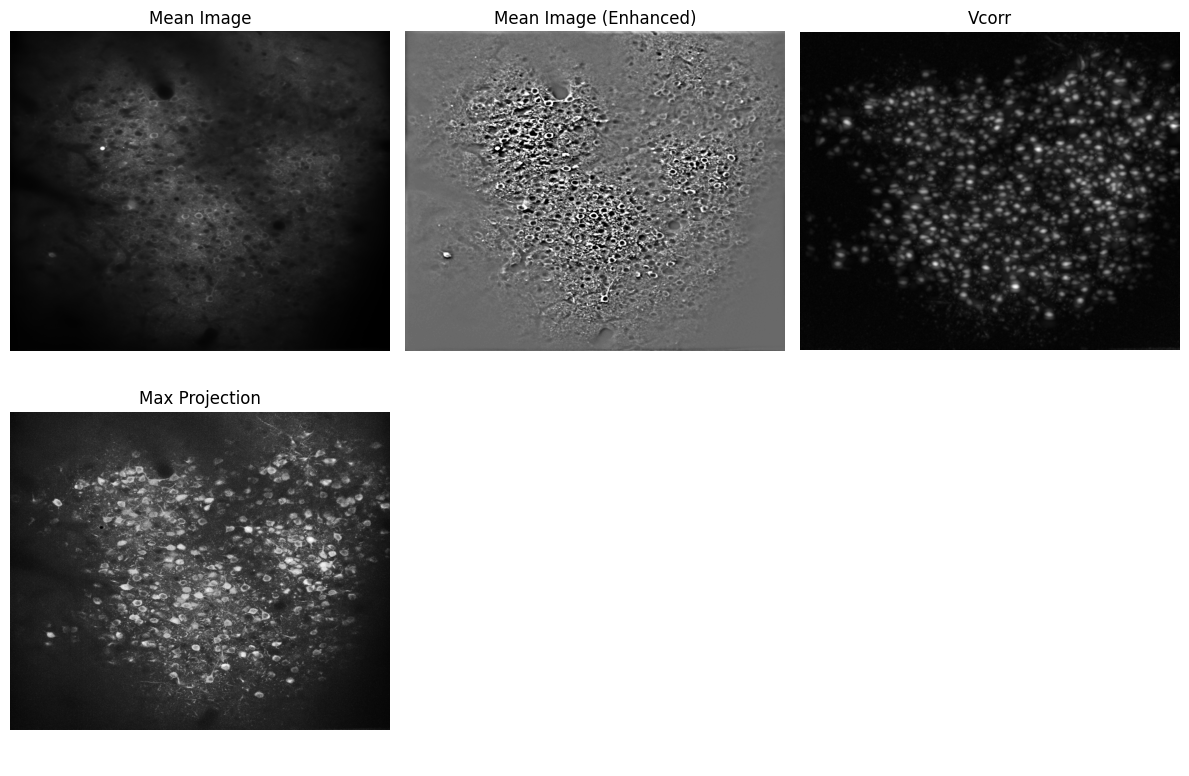

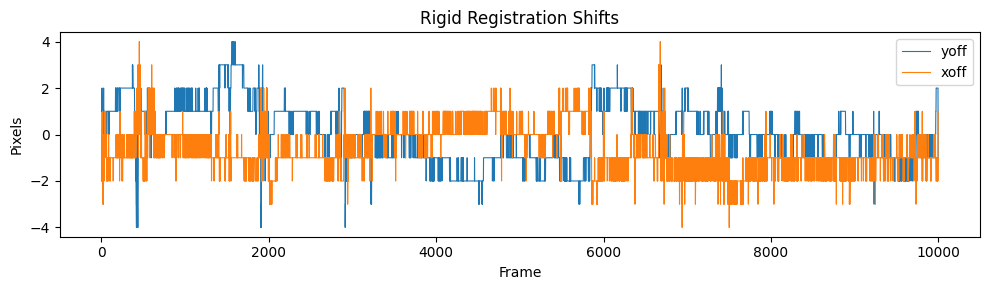

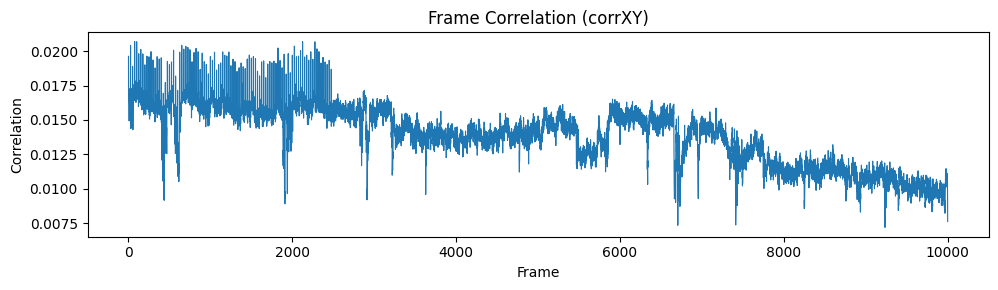

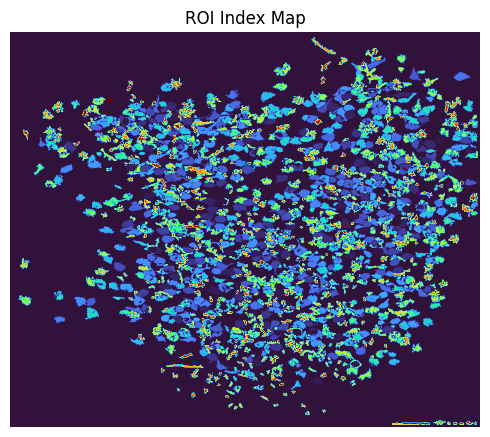

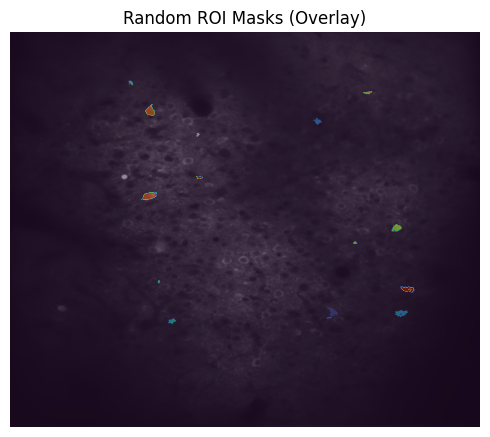

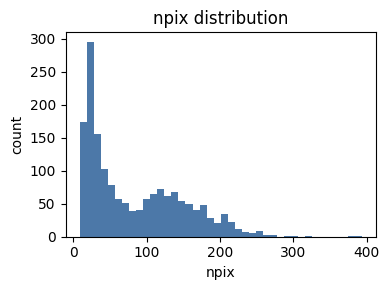

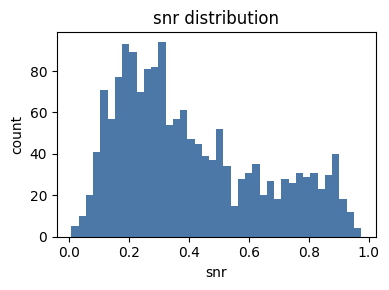

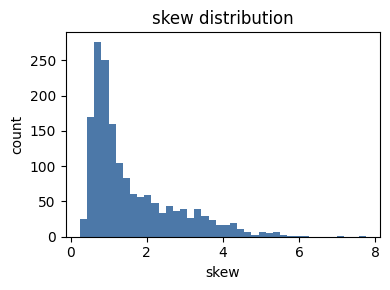

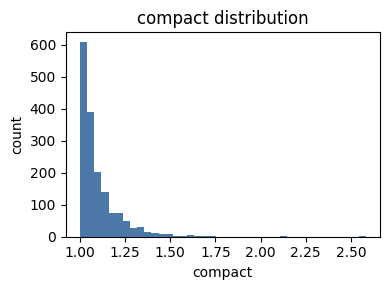

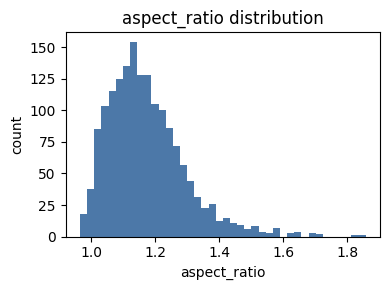

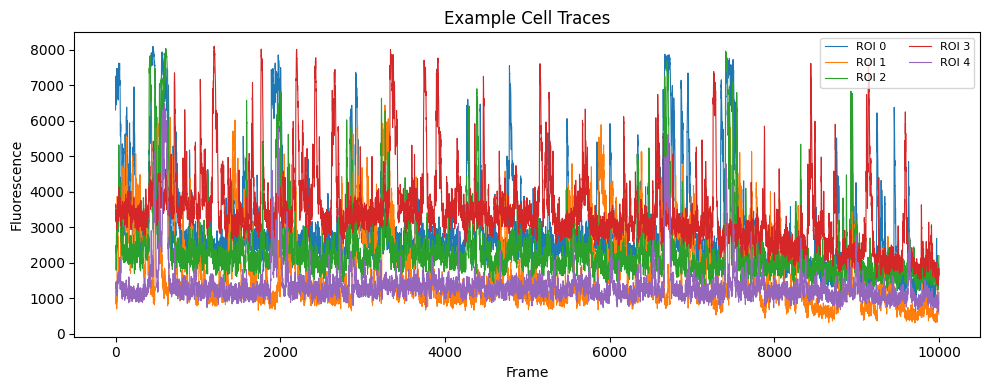

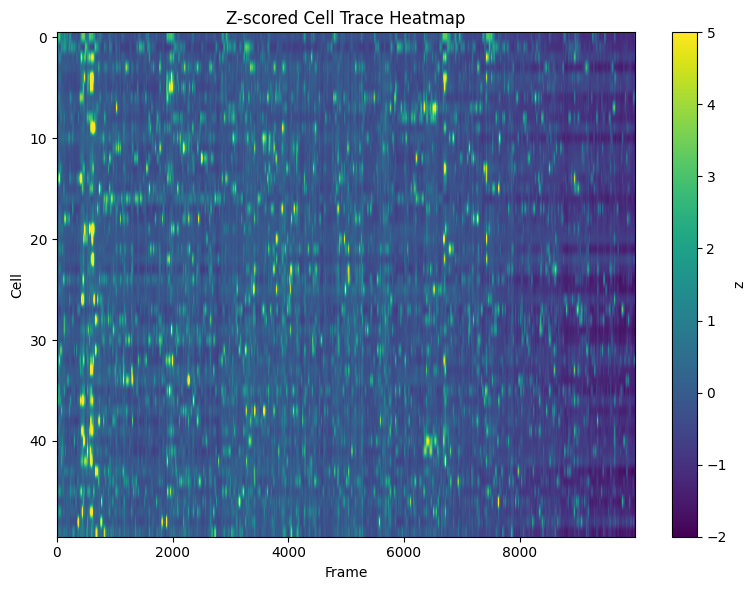

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

def is_image_array(arr):
    return arr.ndim == 2 or (arr.ndim == 3 and arr.shape[-1] in (3, 4))

def show_image_grid(images, titles, cmap="gray", vmax=None):
    n = len(images)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        if i < n:
            ax.imshow(images[i], cmap=cmap, vmax=vmax)
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Image summary panels
img_list = []
img_titles = []
for key, title in [
    ("meanImg", "Mean Image"),
    ("meanImgE", "Mean Image (Enhanced)"),
    ("Vcorr", "Vcorr"),
    ("max_proj", "Max Projection"),
    ("Vmax", "Vmax"),
]:
    if key in ops and ops[key] is not None and is_image_array(ops[key]):
        img_list.append(ops[key])
        img_titles.append(title)
if img_list:
    show_image_grid(img_list, img_titles)

# Variance maps (Vmap) if present
if "Vmap" in ops and ops["Vmap"] is not None:
    vmap = ops["Vmap"]
    if vmap.ndim == 3:
        vmap_imgs = [vmap[i] for i in range(min(3, vmap.shape[0]))]
        vmap_titles = [f"Vmap[{i}]" for i in range(len(vmap_imgs))]
        show_image_grid(vmap_imgs, vmap_titles, cmap="magma")

# Registration shift traces
if "yoff" in ops and "xoff" in ops:
    plt.figure(figsize=(10, 3))
    plt.plot(ops["yoff"], lw=0.8, label="yoff")
    plt.plot(ops["xoff"], lw=0.8, label="xoff")
    plt.title("Rigid Registration Shifts")
    plt.xlabel("Frame")
    plt.ylabel("Pixels")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Frame correlation / metrics
if "corrXY" in ops:
    plt.figure(figsize=(10, 3))
    plt.plot(ops["corrXY"], lw=0.8)
    plt.title("Frame Correlation (corrXY)")
    plt.xlabel("Frame")
    plt.ylabel("Correlation")
    plt.tight_layout()
    plt.show()

# ROI index map (non-overlap)
if len(stat) > 0 and "meanImg" in ops and is_image_array(ops["meanImg"]):
    Ly, Lx = ops["meanImg"].shape[:2]
    roi_map = np.zeros((Ly, Lx), dtype=np.int32)
    for n in range(len(stat)):
        ypix = stat[n]["ypix"][~stat[n].get("overlap", np.zeros_like(stat[n]["ypix"], dtype=bool))]
        xpix = stat[n]["xpix"][~stat[n].get("overlap", np.zeros_like(stat[n]["xpix"], dtype=bool))]
        roi_map[ypix, xpix] = n + 1
    plt.figure(figsize=(5, 5))
    plt.imshow(roi_map, cmap="turbo")
    plt.title("ROI Index Map")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Overlay of random ROI masks on mean image
if "meanImg" in ops and ops["meanImg"] is not None and is_image_array(ops["meanImg"]):
    rng = np.random.default_rng(0)
    n_show = min(15, len(stat))
    if n_show > 0:
        idx = rng.choice(len(stat), size=n_show, replace=False)
        overlay = np.zeros_like(ops["meanImg"], dtype=float)
        for i, s in enumerate(stat[idx]):
            ypix = s["ypix"]
            xpix = s["xpix"]
            overlay[ypix, xpix] = i + 1
        plt.figure(figsize=(5, 5))
        plt.imshow(ops["meanImg"], cmap="gray")
        plt.imshow(overlay, cmap="turbo", alpha=0.5)
        plt.title("Random ROI Masks (Overlay)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# ROI statistic histograms
stat_fields = ["npix", "snr", "skew", "compact", "aspect_ratio"]
for field in stat_fields:
    if field in stat[0]:
        vals = np.array([s.get(field, np.nan) for s in stat])
        vals = vals[~np.isnan(vals)]
        plt.figure(figsize=(4, 3))
        plt.hist(vals, bins=40, color="#4C78A8")
        plt.title(f"{field} distribution")
        plt.xlabel(field)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

# Example traces and heatmap
if cell_mask.any():
    cell_idx = np.where(cell_mask)[0]
    n_traces = min(5, len(cell_idx))
    sel = cell_idx[:n_traces]
    plt.figure(figsize=(10, 4))
    for roi in sel:
        plt.plot(F[roi], lw=0.8, label=f"ROI {roi}")
    plt.title("Example Cell Traces")
    plt.xlabel("Frame")
    plt.ylabel("Fluorescence")
    plt.legend(loc="upper right", ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Heatmap of z-scored traces for top cells
    n_heat = min(50, len(cell_idx))
    heat_idx = cell_idx[:n_heat]
    traces = zscore(F[heat_idx], axis=1)
    plt.figure(figsize=(8, 6))
    plt.imshow(traces, aspect="auto", cmap="viridis", vmin=-2, vmax=5)
    plt.title("Z-scored Cell Trace Heatmap")
    plt.xlabel("Frame")
    plt.ylabel("Cell")
    plt.colorbar(label="z")
    plt.tight_layout()
    plt.show()

In [14]:
cell_mask

array([ True,  True,  True, ..., False, False, False])